### Importing the libraries

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler,PowerTransformer
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV
from sklearn.metrics import make_scorer, roc_auc_score, f1_score, accuracy_score, confusion_matrix, precision_recall_curve,classification_report, roc_curve, auc
import itertools

from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier,RidgeClassifierCV

from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, GradientBoostingClassifier,AdaBoostClassifier

from sklearn.utils import shuffle
%matplotlib inline

### Importing the data

In [2]:
train = pd.read_csv("https://raw.githubusercontent.com/dphi-official/Datasets/master/Loan_Data/loan_train.csv" )
test = pd.read_csv('https://raw.githubusercontent.com/dphi-official/Datasets/master/Loan_Data/loan_test.csv')

In [3]:
train.head()

,Unnamed: 0,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,0,LP002305,Female,No,0,Graduate,No,4547,0.0,115.0,360.0,1.0,Semiurban,1
1,1,LP001715,Male,Yes,3+,Not Graduate,Yes,5703,0.0,130.0,360.0,1.0,Rural,1
2,2,LP002086,Female,Yes,0,Graduate,No,4333,2451.0,110.0,360.0,1.0,Urban,0
3,3,LP001136,Male,Yes,0,Not Graduate,Yes,4695,0.0,96.0,NaN,1.0,Urban,1
4,4,LP002529,Male,Yes,2,Graduate,No,6700,1750.0,230.0,300.0,1.0,Semiurban,1


### EDA

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 491 entries, 0 to 490
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         491 non-null    int64  
 1   Loan_ID            491 non-null    object 
 2   Gender             481 non-null    object 
 3   Married            490 non-null    object 
 4   Dependents         482 non-null    object 
 5   Education          491 non-null    object 
 6   Self_Employed      462 non-null    object 
 7   ApplicantIncome    491 non-null    int64  
 8   CoapplicantIncome  491 non-null    float64
 9   LoanAmount         475 non-null    float64
 10  Loan_Amount_Term   478 non-null    float64
 11  Credit_History     448 non-null    float64
 12  Property_Area      491 non-null    object 
 13  Loan_Status        491 non-null    int64  
dtypes: float64(4), int64(3), object(7)
memory usage: 53.8+ KB


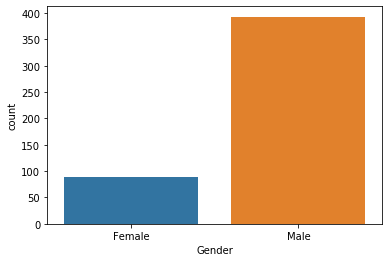

In [5]:
# count plot on single categorical variable
sns.countplot(x ='Gender', data = train)
 
# Show the plot
plt.show()

Observation: Number of male applicants for loan is significantly greater than female applicants.

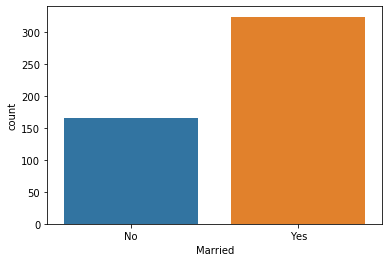

In [6]:
# count plot on single categorical variable
sns.countplot(x ='Married', data = train)
 
# Show the plot
plt.show()

Observation: The applicants who are married are likely to apply for loan.  

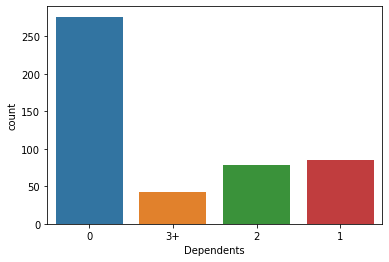

In [7]:
# count plot on single categorical variable
sns.countplot(x ='Dependents', data = train)
 
# Show the plot
plt.show()

Observation: The persons those have less dependants are more likely to apply for loans.

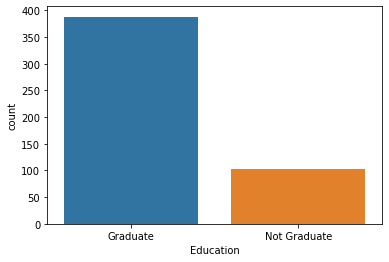

In [8]:
# count plot on single categorical variable
sns.countplot(x ='Education', data = train)
 
# Show the plot
plt.show()

Observation: The number of graduate applicants are more.

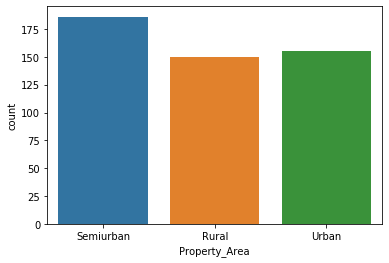

In [9]:
# count plot on single categorical variable
sns.countplot(x ='Property_Area', data = train)
 
# Show the plot
plt.show()

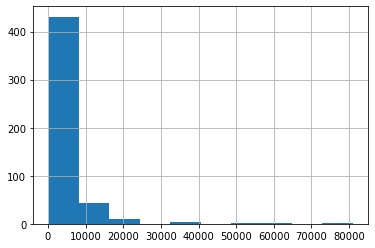

In [10]:
# Histogram of variable ApplicantIncome
train['ApplicantIncome'].hist()

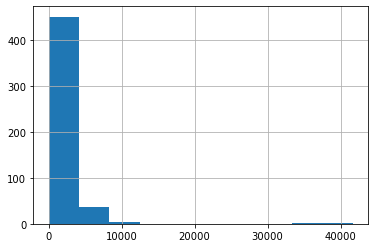

In [11]:
# Histogram of variable ApplicantIncome
train['CoapplicantIncome'].hist()

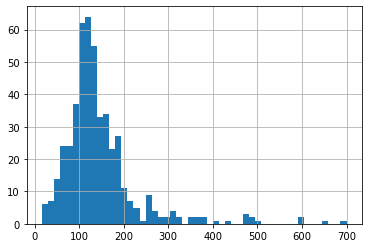

In [12]:
# Histogram of variable LoanAmount
train['LoanAmount'].hist(bins=50)

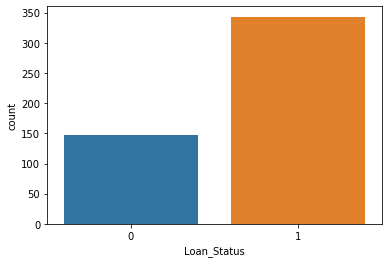

In [13]:
# count plot on single categorical variable
sns.countplot(x ='Loan_Status', data = train)
 
# Show the plot
plt.show()

### Feature Engineering

In [14]:
# Separating labels and features
y = train['Loan_Status']
train_df = train.drop(['Loan_Status'],axis=1)

In [15]:
#Combining both train and test dataset and creating a flag to separate Train and Test Data set later
train_df['Type']='Train' 
test['Type']='Test'
fullData = pd.concat([train_df,test], axis=0)

In [16]:
# Checking for null data
fullData.isnull().sum()

Unnamed: 0           123
Loan_ID                0
Gender                13
Married                3
Dependents            15
Education              0
Self_Employed         32
ApplicantIncome        0
CoapplicantIncome      0
LoanAmount            22
Loan_Amount_Term      14
Credit_History        50
Property_Area          0
Type                   0
dtype: int64

#### Null data treatment

In [17]:
#imputation in categorical data
for col in fullData.select_dtypes(include='object').columns:
      fullData[col] = fullData[col].fillna(fullData[col].mode()[0])

#imputation in numerical data
for col in fullData.select_dtypes(include='number').columns:
      fullData[col] = fullData[col].fillna(fullData[col].median())

In [18]:
fullData.isnull().sum()

Unnamed: 0           0
Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Type                 0
dtype: int64

In [19]:
#Create a new column as Total Income
fullData['TotalIncome']=fullData['ApplicantIncome'] + fullData['CoapplicantIncome']

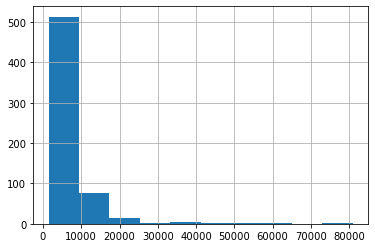

In [20]:
fullData['TotalIncome'].hist()

In [21]:
fullData['TotalIncome'] = np.log(fullData['TotalIncome'])
fullData['LoanAmount'] = np.log(fullData['TotalIncome'])

In [22]:
fullData.head()

,Unnamed: 0,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Type,TotalIncome
0,0.0,LP002305,Female,No,0,Graduate,No,4547,0.0,2.130874,360.0,1.0,Semiurban,Train,8.422223
1,1.0,LP001715,Male,Yes,3+,Not Graduate,Yes,5703,0.0,2.157415,360.0,1.0,Rural,Train,8.648748
2,2.0,LP002086,Female,Yes,0,Graduate,No,4333,2451.0,2.177285,360.0,1.0,Urban,Train,8.822322
3,3.0,LP001136,Male,Yes,0,Not Graduate,Yes,4695,0.0,2.134670,360.0,1.0,Urban,Train,8.454253
4,4.0,LP002529,Male,Yes,2,Graduate,No,6700,1750.0,2.201872,300.0,1.0,Semiurban,Train,9.041922


In [23]:
# Dropping columns
fullData = fullData.drop(['Unnamed: 0','Loan_ID'],axis=1)

In [24]:
fullData.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Type,TotalIncome
0,Female,No,0,Graduate,No,4547,0.0,2.130874,360.0,1.0,Semiurban,Train,8.422223
1,Male,Yes,3+,Not Graduate,Yes,5703,0.0,2.157415,360.0,1.0,Rural,Train,8.648748
2,Female,Yes,0,Graduate,No,4333,2451.0,2.177285,360.0,1.0,Urban,Train,8.822322
3,Male,Yes,0,Not Graduate,Yes,4695,0.0,2.134670,360.0,1.0,Urban,Train,8.454253
4,Male,Yes,2,Graduate,No,6700,1750.0,2.201872,300.0,1.0,Semiurban,Train,9.041922


In [25]:
train_modified=fullData[fullData['Type']=='Train']
test_modified=fullData[fullData['Type']=='Test']

In [26]:
#with drop first
train_modified = pd.get_dummies(train_modified, drop_first=True)
test_modified = pd.get_dummies(test_modified, drop_first=True)

In [27]:
train_modified.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,TotalIncome,Gender_Male,Married_Yes,Dependents_1,Dependents_2,Dependents_3+,Education_Not Graduate,Self_Employed_Yes,Property_Area_Semiurban,Property_Area_Urban
0,4547,0.0,2.130874,360.0,1.0,8.422223,0,0,0,0,0,0,0,1,0
1,5703,0.0,2.157415,360.0,1.0,8.648748,1,1,0,0,1,1,1,0,0
2,4333,2451.0,2.177285,360.0,1.0,8.822322,0,1,0,0,0,0,0,0,1
3,4695,0.0,2.134670,360.0,1.0,8.454253,1,1,0,0,0,1,1,0,1
4,6700,1750.0,2.201872,300.0,1.0,9.041922,1,1,0,1,0,0,0,1,0


In [65]:
# Assigning the feature and labels before modeling
y = y
X = train_modified

In [66]:
X.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,TotalIncome,Gender_Male,Married_Yes,Dependents_1,Dependents_2,Dependents_3+,Education_Not Graduate,Self_Employed_Yes,Property_Area_Semiurban,Property_Area_Urban
0,4547,0.0,2.130874,360.0,1.0,8.422223,0,0,0,0,0,0,0,1,0
1,5703,0.0,2.157415,360.0,1.0,8.648748,1,1,0,0,1,1,1,0,0
2,4333,2451.0,2.177285,360.0,1.0,8.822322,0,1,0,0,0,0,0,0,1
3,4695,0.0,2.134670,360.0,1.0,8.454253,1,1,0,0,0,1,1,0,1
4,6700,1750.0,2.201872,300.0,1.0,9.041922,1,1,0,1,0,0,0,1,0


In [67]:
# Splitting the dataset further into train and validation(75:25)
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [68]:
# Transforming the data to a more Gaussian Form
pt = PowerTransformer()
X_train_pt = pd.DataFrame(pt.fit_transform(X_train), columns=X_train.columns)
X_test_pt = pd.DataFrame(pt.transform(X_test), columns=X_train.columns)

In [69]:
# Scaling the data
scaler = StandardScaler()
X_train_sc= pd.DataFrame(scaler.fit_transform(X_train_pt), columns=X_train_pt.columns)
X_test_sc = pd.DataFrame(scaler.fit_transform(X_test_pt), columns=X_train_pt.columns)


### Model Building

### 1. Logistic Regression

In [70]:
model_lr = LogisticRegression(random_state=0)

In [71]:
param_grid_lr = {
              'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'penalty':['l1', 'l2', 'elasticnet'],
              'max_iter': [50*x for x in range(1,6)]
             }

In [72]:
grid_lr = GridSearchCV(model_lr, param_grid_lr, cv=5 , n_jobs = 2,verbose=1)
grid_lr.fit(X_train, y_train)


Fitting 5 folds for each of 105 candidates, totalling 525 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 460 tasks      | elapsed:    5.4s
[Parallel(n_jobs=2)]: Done 525 out of 525 | elapsed:    5.8s finished


GridSearchCV(cv=5, estimator=LogisticRegression(random_state=0), n_jobs=2,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'max_iter': [50, 100, 150, 200, 250],
                         'penalty': ['l1', 'l2', 'elasticnet']},
             verbose=1)

In [73]:
y_pred_lr = grid_lr.predict(X_test)
acc_lr = accuracy_score(y_test, y_pred_lr) * 100
f1_lr = f1_score(y_test,y_pred_lr) * 100
print("Accuracy for Logistic Regression: ", acc_lr)
print("F1-Score for Logistic Regression: ", f1_lr)

Accuracy for Logistic Regression:  77.23577235772358
F1-Score for Logistic Regression:  84.0909090909091


In [37]:
import scikitplot.metrics as skplt

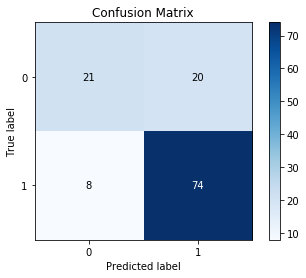

In [38]:
# Plotting the confusion matrix
skplt.plot_confusion_matrix(y_test ,y_pred_lr)

In [39]:
grid_lr_sc = GridSearchCV(model_lr, param_grid_lr, cv=5 , n_jobs = 2,verbose=1)
grid_lr_sc.fit(X_train_sc, y_train)

Fitting 5 folds for each of 105 candidates, totalling 525 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 525 out of 525 | elapsed:    1.4s finished


GridSearchCV(cv=5, estimator=LogisticRegression(random_state=0), n_jobs=2,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'max_iter': [50, 100, 150, 200, 250],
                         'penalty': ['l1', 'l2', 'elasticnet']},
             verbose=1)

In [40]:
y_pred_lr_sc = grid_lr_sc.predict(X_test_sc)
acc_lr_sc = accuracy_score(y_test, y_pred_lr) * 100
f1_lr_sc = f1_score(y_test,y_pred_lr) * 100
print("Accuracy on scaled data for Logistic Regression: ", acc_lr_sc)
print("F1-Score on scaled data for Logistic Regression: ", f1_lr_sc)

Accuracy on scaled data for Logistic Regression:  0.7723577235772358
F1-Score on scaled data for Logistic Regression:  0.8409090909090909


In [63]:
acc_lr =  0.7723577235772358
f1_lr = 0.8409090909090909

### Model 2: Ridge Classifier

In [42]:
alphas = np.array([1,0.1,0.01,0.001,0.0001] )
param_grid_ridge = dict(alpha=alphas) 

In [43]:
grid_ridge = GridSearchCV(RidgeClassifier(random_state=0), param_grid=param_grid_ridge,  cv=3 , n_jobs = 2,verbose=1)
grid_ridge.fit(X_train_sc,y_train)
print(grid_ridge.best_estimator_)


Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


RidgeClassifier(random_state=0)


[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed:    1.2s finished


In [79]:
y_pred_ridge = grid_ridge.predict(X_test_sc)
acc_ridge = accuracy_score(y_test, y_pred_ridge) * 100
f1_ridge = f1_score(y_test,y_pred_ridge) * 100
print("Accuracy for Ridge Classifier: ", acc_ridge)
print("F1-Score for Ridge Classifier: ", f1_ridge)

Accuracy for Ridge Classifier:  78.04878048780488
F1-Score for Ridge Classifier:  85.4054054054054


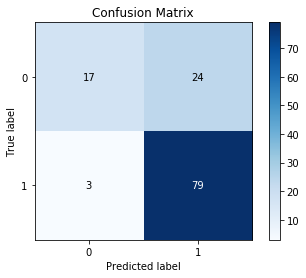

In [45]:
# Plotting the confusion matrix
skplt.plot_confusion_matrix(y_test ,y_pred_ridge)

### Model 3: Random Forest Classifier

In [46]:
param_grid_rf = {
              'min_samples_leaf': [2, 3, 4, 5],
              'min_samples_split':[2,3,4],
              'n_estimators': np.arange(80,300,20),
              'criterion': ['entropy','gini'],
              'max_features': ["auto", "sqrt", "log2"]
             }

In [47]:
model_rf = RandomForestClassifier(random_state=0)
grid_rf = GridSearchCV(model_rf, param_grid_rf, cv=5 , n_jobs = 2,verbose=1)
grid_rf.fit(X_train,y_train)


Fitting 5 folds for each of 792 candidates, totalling 3960 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   10.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   40.5s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  1.5min
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:  2.7min
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:  4.2min
[Parallel(n_jobs=2)]: Done 1796 tasks      | elapsed:  6.2min
[Parallel(n_jobs=2)]: Done 2446 tasks      | elapsed:  8.3min
[Parallel(n_jobs=2)]: Done 3196 tasks      | elapsed: 10.6min
[Parallel(n_jobs=2)]: Done 3960 out of 3960 | elapsed: 13.0min finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0), n_jobs=2,
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [2, 3, 4, 5],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': array([ 80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280])},
             verbose=1)

In [76]:
y_pred_rf = grid_rf.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf) * 100
f1_rf = f1_score(y_test,y_pred_rf) * 100
print("Accuracy for RandomForest: ", acc_rf)
print("F1-Score for RandomForest: ", f1_rf)

Accuracy for RandomForest:  77.23577235772358
F1-Score for RandomForest:  84.61538461538461


In [49]:
model_rf = RandomForestClassifier(random_state=0)
grid_rf_sc = GridSearchCV(model_rf, param_grid_rf, cv=5 , n_jobs = 2,verbose=1)
grid_rf_sc.fit(X_train_sc,y_train)

Fitting 5 folds for each of 792 candidates, totalling 3960 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    8.3s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   38.9s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  1.5min
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:  2.6min
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:  4.1min
[Parallel(n_jobs=2)]: Done 1796 tasks      | elapsed:  5.9min
[Parallel(n_jobs=2)]: Done 2446 tasks      | elapsed:  7.9min
[Parallel(n_jobs=2)]: Done 3196 tasks      | elapsed: 10.3min
[Parallel(n_jobs=2)]: Done 3960 out of 3960 | elapsed: 12.6min finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0), n_jobs=2,
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [2, 3, 4, 5],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': array([ 80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280])},
             verbose=1)

In [77]:
y_pred_rf_sc = grid_rf_sc.predict(X_test_sc)
acc_rf_sc = accuracy_score(y_test, y_pred_rf) * 100
f1_rf_sc = f1_score(y_test,y_pred_rf) * 100
print("Accuracy on scaled data for RandomForest: ","%0.3f" % acc_rf_sc)
print("F1-Score on scaled data for RandomForest: ","%0.3f" % f1_rf_sc)

Accuracy on scaled data for RandomForest:  77.236
F1-Score on scaled data for RandomForest:  84.615


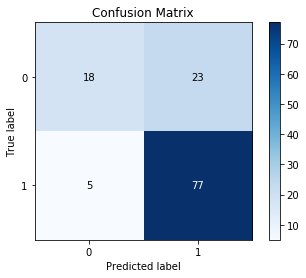

In [51]:
# Plotting the confusion matrix
skplt.plot_confusion_matrix(y_test ,y_pred_rf)

### Model 4: XGBoost

In [52]:
param_grid_xgb = {
                  'n_estimators': np.arange(100,500,100),
                  'loss': ['deviance', 'exponential'],
                  'eta': [0.01, 0.1, 1, 5],
                  'min_child_weight':[1, 2, 3],
                  'max_depth': [5,6,7]
                }

In [53]:
model_xgb = XGBClassifier(random_state=0)
grid_xgb = GridSearchCV(model_xgb, param_grid_xgb, cv=5 , n_jobs = 2,verbose=1)
grid_xgb.fit(X_train,y_train)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  62 tasks      | elapsed:    5.3s
[Parallel(n_jobs=2)]: Done 362 tasks      | elapsed:   25.3s
[Parallel(n_jobs=2)]: Done 862 tasks      | elapsed:   54.5s


[15:52:46] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { loss } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[Parallel(n_jobs=2)]: Done 1440 out of 1440 | elapsed:  1.2min finished


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=0,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, va

In [78]:
y_pred_xgb = grid_xgb.predict(X_test)
acc_xgb = accuracy_score(y_test, y_pred_xgb)* 100
f1_xgb = f1_score(y_test,y_pred_xgb) * 100
print("Accuracy for XGBoost Classifier: ","%0.3f" % acc_xgb)
print("F1-Score for XGBoost Classifier: ","%0.3f" % f1_xgb)

Accuracy for XGBoost Classifier:  77.236
F1-Score for XGBoost Classifier:  84.615


In [87]:
# Creating table using PrettyTable library
from prettytable import PrettyTable

names = ["Logistic Regression", "Ridge Classifier", "Random Forest", \
        "XGBoost Classifier"]


test_acc = ["%0.2f"%acc_lr, "%0.2f"%acc_ridge,"%0.2f"% acc_rf,"%0.2f"% acc_xgb]
f1_score = ["%0.2f"%f1_lr,"%0.2f"% f1_ridge,"%0.2f"% f1_rf,"%0.2f"% f1_xgb]

numbering = [1,2,3,4]

# Initializing prettytable
ptable = PrettyTable()

# Adding columns
ptable.add_column("S.NO.",numbering)
ptable.add_column("MODEL",names)
ptable.add_column("Test Accuracy",test_acc)
ptable.add_column("F1-Score",f1_score)

# Printing the Table
print(ptable)

+-------+---------------------+---------------+----------+
| S.NO. |        MODEL        | Test Accuracy | F1-Score |
+-------+---------------------+---------------+----------+
|   1   | Logistic Regression |     77.24     |  84.09   |
|   2   |   Ridge Classifier  |     78.05     |  85.41   |
|   3   |    Random Forest    |     77.24     |  84.62   |
|   4   |  XGBoost Classifier |     77.24     |  84.62   |
+-------+---------------------+---------------+----------+


Conclusion: From the above table, ridge classifer is the best algorithm.